## Import libraries

In [1]:
import numpy as np
import pandas as pd
import pickle

from functools import partial
from pyts.image import GADF, GASF, MTF
import matplotlib.pyplot as plt
import numexpr as ne
import time
from multiprocessing import Pool, cpu_count

from pykalman import KalmanFilter

from data_processing_func import *

import warnings
warnings.filterwarnings('ignore')

## Load preprocessed data

In [3]:
data_path = 'data/'
with open(data_path+'stockData_'+str(1),'rb') as p:
    df = pickle.load(p)
    p.close()

for i in range(1, 27):
    with open(data_path+'stockData_'+str(i+1), 'rb') as p:
        df1 = pickle.load(p)
        df = pd.concat([df, df1])
        p.close()

df = df.reset_index(drop=False).set_index(['PERMNO','date'])

## Data overview
Following codes summarize the data in various aspects:

1) Number of stocks;

2) Number of trading dates;

3) Starting vs ending dates;

4) Numberof features and names of the features.

In [4]:
all_permno = np.unique([x[0] for x in df.index.values])
all_dates = np.unique([x[1] for x in df.index.values])
nFeatures = df.shape[1]

print('# of stocks:', len(all_permno))
print('# of days:', len(all_dates))
print('starting from:', all_dates.min(), 'ending at:', all_dates.max())
print('# of features:', nFeatures)
print('features:', df.columns.values)

# of stocks: 1367
# of days: 5539
starting from: 19960102 ending at: 20171229
# of features: 4
features: ['PRC' 'VOL' 'BIDLO' 'ASKHI']


In [4]:
# Some sample data
print(df.head())
print(df.tail())

                    PRC       VOL   BIDLO   ASKHI
PERMNO date                                      
63773  19960102  39.750   61400.0  39.125  39.875
       19960103  39.875  105000.0  39.500  40.125
       19960104  39.750   69500.0  39.500  40.000
       19960105  40.500   42800.0  39.375  40.500
       19960108  40.125   46300.0  40.125  40.625
                   PRC        VOL  BIDLO  ASKHI
PERMNO date                                    
56274  20171222  38.08  2880973.0  37.92  38.26
       20171226  38.21  1890332.0  38.02  38.63
       20171227  38.07  2696672.0  37.95  38.36
       20171228  38.05  1876344.0  37.68  38.22
       20171229  37.67  2392097.0  37.65  38.24


## Convert multidimensional time series into multichannel images
This section is based on Wang and Oates (2015), where they propose a polar transformation for 1-d time series to map them into a 2 dimensional matrix. Applying this idea, we map a n-d time series into a n-channel images, by stacking 1-d time series converted signle channel images.

### Some hyperparameters setup
Descriptions of some hyperparameters:
    1. image_size: # of pixels for each channel in an image. If image_size<length of time-series, PAA will be applied.
    2. data_len: length of the time series to construct one single image. Default to 252/4, i.e. one quarter of data.
    3. retrain_freq: for how many days do we re-generate an image, which also decides our portfolio rebalance frequency. Default to 5, i.e. weekly rebalance.

Notice that data_len/image_size determines how heavily you compress information from the image. Alos, retrain_freq closely associated with variation within samples, as too low retrain_freq results in small differences within samples, giving useless training samples, while too large retrain_freq results in too small sample size.

In [5]:
image_size = 16 # Compress information for every 4 days;
data_len = int(252/4)+1
retrain_freq = 5
nDays = len(all_dates)

## 1-D demo
The following provides a 1-D time series example. Only use price feature to convert time series into a single channel image.

In [6]:
OneDimSample = df['PRC']

# Example of graphs of one stock throuhgout the sampling period.

OneStock1d = OneDimSample.loc[df.index.values[0][0]].values.reshape((1, -1))
gadf, gasf, mtf = GADF(image_size), GASF(image_size), MTF(image_size)
_gadf, _gasf, _mtf = [], [], []

for i in range(data_len, nDays, retrain_freq):
    series = OneStock1d[:, i-data_len:i]
    _gadf.append(gadf.fit_transform(series))
    _gasf.append(gasf.fit_transform(series))
    _mtf.append(mtf.fit_transform(series))

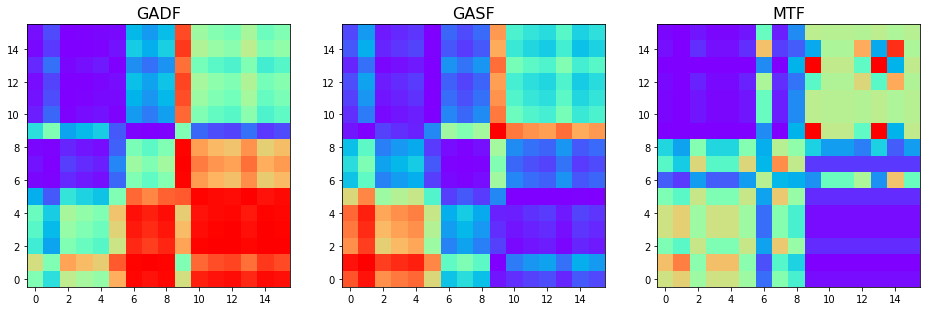

In [7]:
# Plot the 1st image (i.e. image generated by first data_len days)

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(_gadf[0].squeeze(), cmap='rainbow', origin='lower')
plt.title('GADF', fontsize=16)
plt.subplot(132)
plt.imshow(_gasf[0].squeeze(), cmap='rainbow', origin='lower')
plt.title('GASF', fontsize=16)
plt.subplot(133)
plt.imshow(_mtf[0].squeeze(), cmap='rainbow', origin='lower')
plt.title('MTF', fontsize=16)
plt.show()

### 4-D demo
The following provides a 4-D time series example. These 4 features will be used throughout the project.

In [8]:
OneStock4d = df.loc[df.index.values[0][0]].T
gadf, gasf, mtf = GADF(image_size), GASF(image_size), MTF(image_size)
_gadf, _gasf, _mtf = [], [], []

for i in range(data_len, nDays, retrain_freq):
    series = OneStock4d.iloc[:, i-data_len:i].values
    _gadf.append(gadf.fit_transform(series))
    _gasf.append(gasf.fit_transform(series))
    _mtf.append(mtf.fit_transform(series))

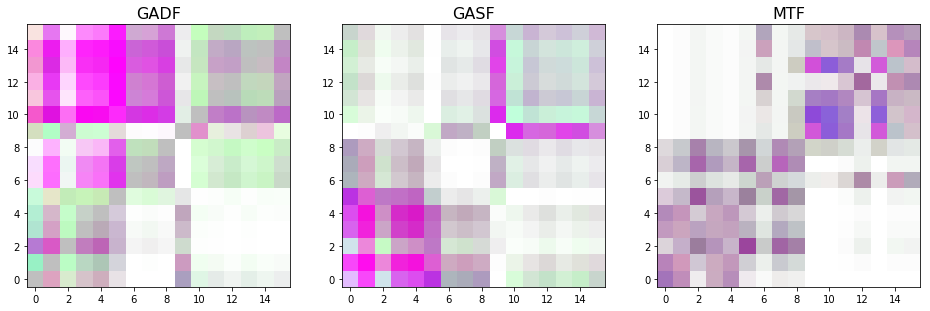

In [9]:
# Plot the 1st image (i.e. image generated by first data_len days)

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow((_gadf[0].T+1)/2, cmap='rainbow', origin='lower')
plt.title('GADF', fontsize=16)
plt.subplot(132)
plt.imshow((1+_gasf[0].T)/2, cmap='rainbow', origin='lower')
plt.title('GASF', fontsize=16)
plt.subplot(133)
plt.imshow((_mtf[0].T), cmap='rainbow', origin='lower')
plt.title('MTF', fontsize=16)
plt.show()

## Prepare all samples for training and testing
The following class gives a general way to convert series of historical data of one stock into images. Only GADF and GASF are considered, since MTF will result in large information loss when we consider only a short period of time (not enough quantile bins to record enough transition information).

An alternative way to implement denoising autoencoder is proposed, by converting images of kalman smoothed and unsmoothed data. Applying this technique, one could try to train with noisy data to recover smoothed images, and extract useful features from it.

In [6]:
cnn_sample_path = data_path + 'cnn samples/'

In [13]:
def partial_call(data):
    return CNNSamples().getTimeSeriesCNNSample(data)

for i in range(27):
    start_time = time.time()
    
    df1 = df.reset_index(level=0, drop=False)
    iv = df1.PERMNO
    df_by_permno = [df1[ne.evaluate('iv==x')] for x in all_permno[50*i:50*(i+1)]]
    
    result = []
    for dbp in df_by_permno:
        result.append(partial_call(dbp))
        
##    Run with multiprocessing when applicable
#     with Pool(cpu_count()) as pool:
#         result = pool.map(partial_call, df_by_permno)
#         pool.close()
#         pool.join()
    
    with open(cnn_sample_path+'CNNSamples_'+str(i+1), 'wb') as p:
        pickle.dump(result, p)
        p.close()
    
    print("--- %s seconds ---" % (time.time()-start_time))

--- 61.33695673942566 seconds ---
--- 61.806806564331055 seconds ---
--- 61.81224775314331 seconds ---
--- 60.99805498123169 seconds ---
--- 61.56109380722046 seconds ---
--- 61.66808748245239 seconds ---
--- 61.479650259017944 seconds ---
--- 61.456772804260254 seconds ---
--- 61.92937970161438 seconds ---
--- 61.528236865997314 seconds ---
--- 62.02419328689575 seconds ---
--- 61.49162244796753 seconds ---
--- 62.20219540596008 seconds ---
--- 60.653315782547 seconds ---
--- 61.73614764213562 seconds ---
--- 62.05557894706726 seconds ---
--- 61.21392107009888 seconds ---
--- 61.57807779312134 seconds ---
--- 61.44490194320679 seconds ---
--- 61.62975740432739 seconds ---
--- 61.411914348602295 seconds ---
--- 61.87991786003113 seconds ---
--- 61.48481225967407 seconds ---
--- 61.54215908050537 seconds ---
--- 61.89020657539368 seconds ---
--- 60.97550344467163 seconds ---
--- 25387.907150030136 seconds ---


## Get the target for training and testing
Calcululate target return based on VWAP instead of pure return calculated with close prices. Could serve to denoise.

In [11]:
start_time = time.time()

df1 = df.reset_index(level=0, drop=False).reset_index(drop=False)
iv = df1.PERMNO
df_by_permno = [df1[ne.evaluate('iv==x')] for x in all_permno[:27*50]]

res = []
for dbp in df_by_permno:
    res.append(getTimeSeriesCNNTarget(dbp))
    
# # Run with multiprocessing when applicable
# with Pool(cpu_count()) as pool:
#     res = pool.map(getTimeSeriesCNNTarget, df_by_permno)
#     p.close()
#     p.join()

with open(cnn_sample_path+'CNNSamples_target', 'wb') as p:
    pickle.dump(res, p)
    p.close()

print("--- %s seconds ---" % (time.time()-start_time))

--- 559.262674331665 seconds ---
